In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [3]:
# 2. Đọc file dữ liệu Gas&Electric và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/1.PTDLKD/Dataset/SSI_STOCK.csv', parse_dates=True, index_col='Date')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

<ipython-input-3-a8c4e49d2f40>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv('/content/drive/MyDrive/1.PTDLKD/Dataset/SSI_STOCK.csv', parse_dates=True, index_col='Date')


In [4]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.8 MB/s eta 0:00:00


In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=15287.936, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=15024.167, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=14911.326, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=14817.103, Time=0.21 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=14767.023, Time=0.29 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=14761.940, Time=0.25 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=2.54 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=5.09 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=14763.968, Time=1.77 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 11.697 seconds


ARIMA(order=(5, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [6]:
print(model.fit(y_train).summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  965
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -7374.970
Date:                Sat, 17 Jun 2023   AIC                          14761.940
Time:                        03:53:47   BIC                          14791.161
Sample:                             0   HQIC                         14773.066
                                - 965                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8538      0.019    -46.021      0.000      -0.890      -0.817
ar.L2         -0.7126      0.024    -29.301      0.000      -0.760      -0.665
ar.L3         -0.5461      0.027    -20.365      0.0

In [7]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [8]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[36619.75722584 36692.34115506 36625.47725795 36543.15638183
 36550.29881751 36587.46459417 36595.56122393 36574.67026128
 36557.24457467 36556.79282152 36561.4143239  36558.89473487
 36550.9970031  36544.61037418 36541.7040031  36539.40535654
 36535.50439766 36530.63820685 36526.23135776 36522.51799071
 36518.84289961 36514.8159846  36510.62693969 36506.55867106
 36502.62477788 36498.68122279 36494.66273347 36490.61910865
 36486.6049822  36482.61604366]


In [9]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 15881.635933428159
Testing RMSE: 11636.342472458506


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Đánh giá độ chính xác thuật toán bằng MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 15737.504403841796
Testing MAE: 9976.826662658961


In [11]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = (np.sum(np.abs((y_val-y_pred_val)/y_val))/len(y_val))*100
test_mape = (np.sum(np.abs((y_test-y_pred)/y_test))/len(y_test))*100
print(f"Validation MAPE: {valid_mape:.2f}%")
print(f"Testing MAPE: {test_mape:.2f}%")

Validation MAPE: 78.17%
Testing MAPE: 44.48%


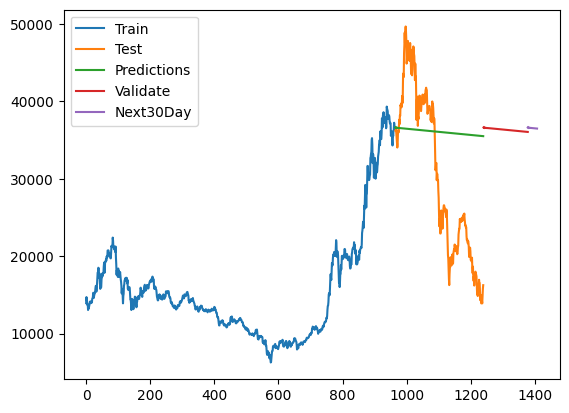

In [12]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()